In [2]:
# IMPORTING PACKAGES

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [3]:
# EXTRACTING STOCK DATA

def get_historical_data(symbol, start_date):
    api_key = '91b69afa6c474612a50e9e707efdd54b'
    api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&interval=1day&outputsize=5000&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['values']).iloc[::-1].set_index('datetime').astype(float)
    df = df[df.index >= start_date]
    df.index = pd.to_datetime(df.index)
    return df

aapl = get_historical_data('MMM', '2022-01-01')
aapl


,open,high,low,close,volume
datetime,,,,,
2022-01-03,178.32001,179.09000,175.84000,177.74001,1930957.0
2022-01-04,178.48000,181.25999,178.02499,180.23000,2522194.0
2022-01-05,177.13000,181.78000,177.00000,179.49001,2952404.0
2022-01-06,180.88000,181.28000,177.53999,178.00000,2505540.0
2022-01-07,178.13000,180.49001,177.22000,179.95000,2800232.0
...,...,...,...,...,...
2023-09-13,107.14000,107.47000,100.51000,101.05000,7575100.0
2023-09-14,101.60000,103.57000,101.21000,102.32000,4184100.0
2023-09-15,101.89000,102.41000,100.65000,101.06000,6002200.0


In [25]:
# STOCHASTIC OSCILLATOR CALCULATION

def get_stoch_osc(high, low, close, k_lookback, d_lookback):
    lowest_low = low.rolling(k_lookback).min()
    highest_high = high.rolling(k_lookback).max()
    k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
    d_line = k_line.rolling(d_lookback).mean()
    return k_line, d_line

aapl['%k'], aapl['%d'] = get_stoch_osc(aapl['high'], aapl['low'], aapl['close'], 14, 3)
aapl.tail()

,open,high,low,close,volume,%k,%d
datetime,,,,,,,
2023-08-14,177.97,179.69000,177.31000,179.46001,43675600.0,14.092058,8.283910
2023-08-15,178.88,179.48000,177.05000,177.45000,43622600.0,4.358354,8.151735
2023-08-16,177.13,178.53999,176.50000,176.57001,46964900.0,0.346070,6.265494
2023-08-17,177.14,177.50999,173.48000,174.00000,66062900.0,2.236559,2.313661
2023-08-18,172.30,175.10001,171.96001,174.49001,61114200.0,10.213973,4.265534


In [26]:
# MACD CALCULATION

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    return macd, signal, hist

aapl['macd'] = get_macd(aapl['close'], 26, 12, 9)[0]
aapl['macd_signal'] = get_macd(aapl['close'], 26, 12, 9)[1]
aapl['macd_hist'] = get_macd(aapl['close'], 26, 12, 9)[2]
aapl = aapl.dropna()
aapl.tail()

,open,high,low,close,volume,%k,%d,macd,macd_signal,macd_hist
datetime,,,,,,,,,,
2023-08-14,177.97,179.69000,177.31000,179.46001,43675600.0,14.092058,8.283910,-2.849526,-0.979334,-1.870192
2023-08-15,178.88,179.48000,177.05000,177.45000,43622600.0,4.358354,8.151735,-3.112901,-1.406047,-1.706853
2023-08-16,177.13,178.53999,176.50000,176.57001,46964900.0,0.346070,6.265494,-3.353972,-1.795632,-1.558340
2023-08-17,177.14,177.50999,173.48000,174.00000,66062900.0,2.236559,2.313661,-3.709639,-2.178434,-1.531205
2023-08-18,172.30,175.10001,171.96001,174.49001,61114200.0,10.213973,4.265534,-3.906931,-2.524133,-1.382798


In [27]:
# TRADING STRATEGY

def implement_stoch_macd_strategy(prices, k, d, macd, macd_signal):    
    buy_price = []
    sell_price = []
    stoch_macd_signal = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < 30 and d[i] < 30 and macd[i] < -2 and macd_signal[i] < -2:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
                
        elif k[i] > 70 and d[i] > 70 and macd[i] > 2 and macd_signal[i] > 2:
            if signal != -1 and signal != 0:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
        
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_macd_signal.append(0)
            
    return buy_price, sell_price, stoch_macd_signal
            
buy_price, sell_price, stoch_macd_signal = implement_stoch_macd_strategy(aapl['close'], aapl['%k'], aapl['%d'], aapl['macd'], aapl['macd_signal'])

In [28]:
# POSITION

position = []
for i in range(len(stoch_macd_signal)):
    if stoch_macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(aapl['close'])):
    if stoch_macd_signal[i] == 1:
        position[i] = 1
    elif stoch_macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = aapl['close']
k_line = aapl['%k']
d_line = aapl['%d']
macd_line = aapl['macd']
signal_line = aapl['macd_signal']
stoch_macd_signal = pd.DataFrame(stoch_macd_signal).rename(columns = {0:'stoch_macd_signal'}).set_index(aapl.index)
position = pd.DataFrame(position).rename(columns = {0:'stoch_macd_position'}).set_index(aapl.index)

frames = [close_price, k_line, d_line, macd_line, signal_line, stoch_macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,%k,%d,macd,macd_signal,stoch_macd_signal,stoch_macd_position
datetime,,,,,,,
2022-01-25,159.78000,19.945033,14.994076,-4.941067,-3.502229,1,1
2022-01-26,159.69000,22.197519,22.215600,-5.215795,-3.844943,0,1
2022-01-27,159.22000,20.106771,20.749774,-5.409092,-4.157773,0,1
2022-01-28,170.33000,69.528501,37.277597,-4.612626,-4.248743,0,1
2022-01-31,174.78000,89.323883,59.653051,-3.581063,-4.115207,0,1
...,...,...,...,...,...,...,...
2023-08-14,179.46001,14.092058,8.283910,-2.849526,-0.979334,0,0
2023-08-15,177.45000,4.358354,8.151735,-3.112901,-1.406047,0,0
2023-08-16,176.57001,0.346070,6.265494,-3.353972,-1.795632,0,0


In [29]:
# BACKTESTING

aapl_ret = pd.DataFrame(np.diff(aapl['close'])).rename(columns = {0:'returns'})
stoch_macd_strategy_ret = []

for i in range(len(aapl_ret)):
    try:
        returns = aapl_ret['returns'][i] * strategy['stoch_macd_position'][i]
        stoch_macd_strategy_ret.append(returns)
    except:
        pass
    
stoch_macd_strategy_ret_df = pd.DataFrame(stoch_macd_strategy_ret).rename(columns = {0:'stoch_macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value / aapl['close'][0])
stoch_macd_investment_ret = []

for i in range(len(stoch_macd_strategy_ret_df['stoch_macd_returns'])):
    returns = number_of_stocks * stoch_macd_strategy_ret_df['stoch_macd_returns'][i]
    stoch_macd_investment_ret.append(returns)

stoch_macd_investment_ret_df = pd.DataFrame(stoch_macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(stoch_macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret / investment_value) * 100)
print(cl('Profit gained from the STOCH MACD strategy by investing $100k in AAPL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the STOCH MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the STOCH MACD strategy by investing $100k in AAPL : 15143.75
Profit percentage of the STOCH MACD strategy : 15%


In [5]:
#Parse the API response and select only last 1200 days of prices
amzn = amzn.iloc[-1200:]

In [9]:
#20 days to represent the 22 trading days in a month
amzn['20d'] = amzn['close'].rolling(20).mean()
amzn['250d'] = amzn['close'].rolling(250).mean()

/tmp/ipykernel_22689/3186308390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amzn['20d'] = amzn['close'].rolling(20).mean()
/tmp/ipykernel_22689/3186308390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amzn['250d'] = amzn['close'].rolling(250).mean()


Text(0, 0.5, 'Price')

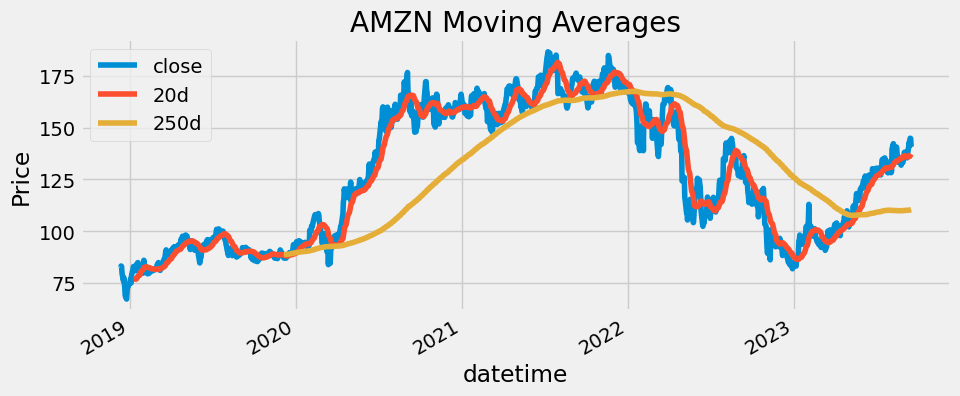

In [10]:
amzn[['close','20d','250d']].plot(figsize=(10,4))
plt.grid(True)
plt.title("AMZN" + ' Moving Averages')
plt.axis('tight')
plt.ylabel('Price')